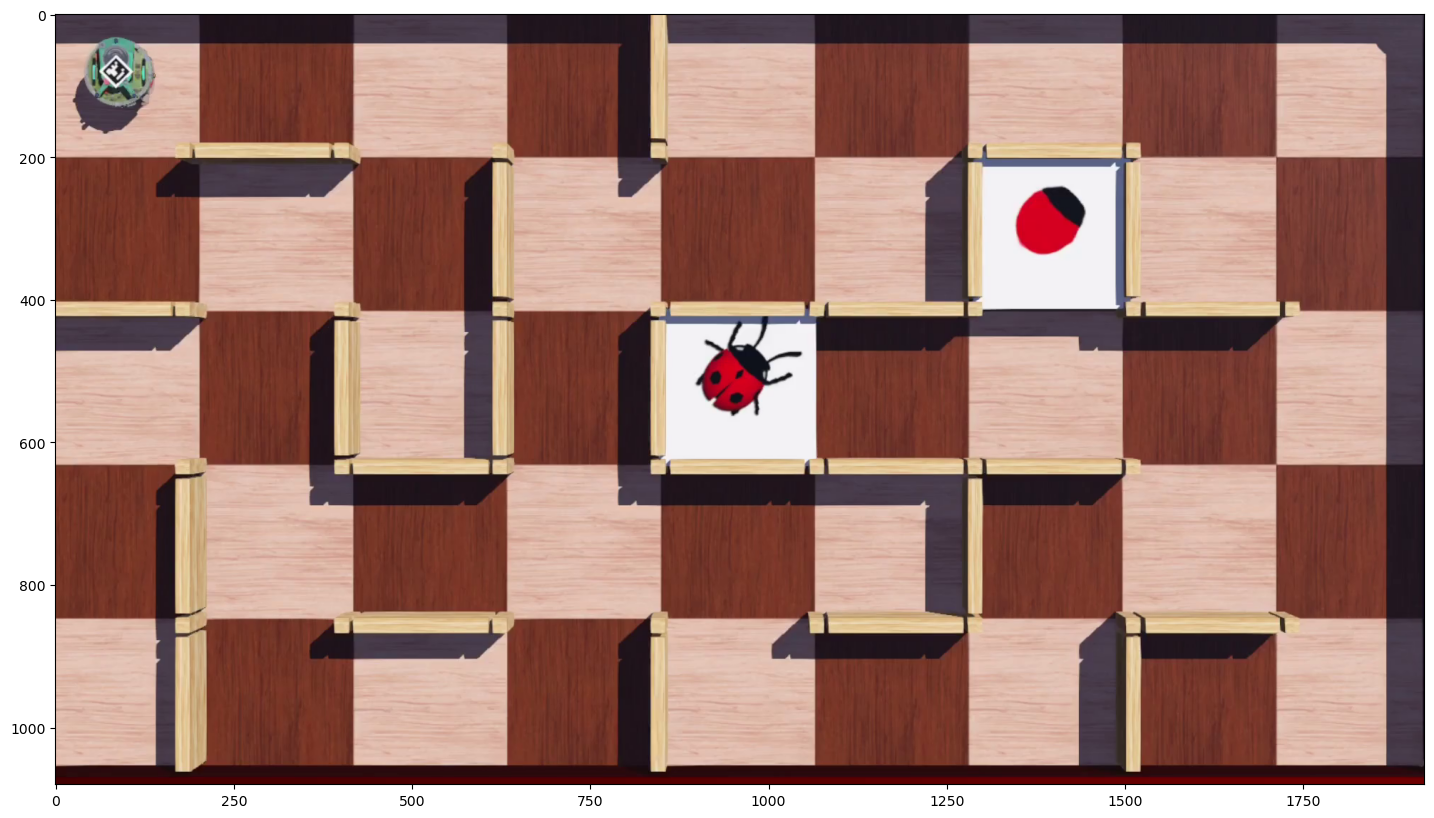

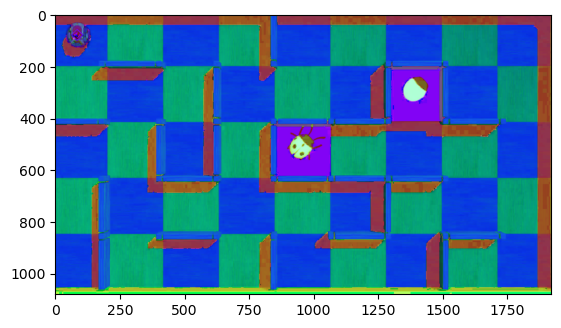

In [1]:
import numpy as np
import cv2 as cv
import argparse
import matplotlib.pyplot as plt # Matplotlib library for plotting

cap = cv.VideoCapture('../MotionTracking.mp4')
# take first frame of the video
ret,frame = cap.read()
img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
img_hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
plt.figure(figsize = (18, 10))
plt.imshow(img)
plt.show()
plt.imshow(img_hsv)
plt.show()

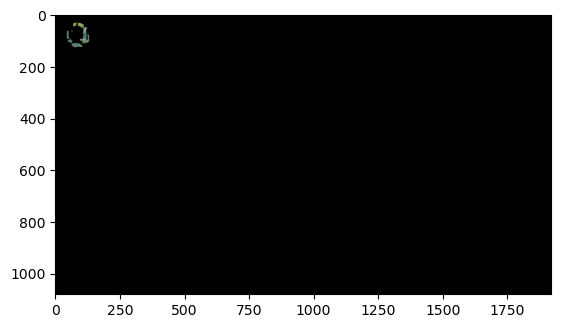

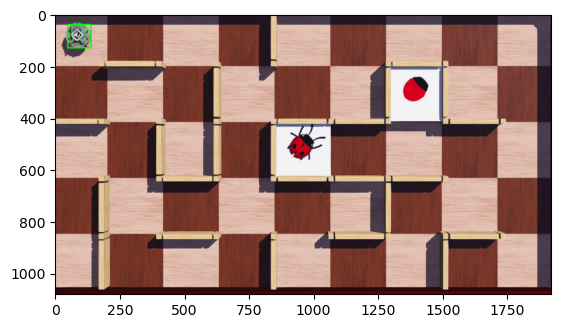

In [2]:
import cv2
Robot = cv2.inRange(img_hsv, (22,0,85), (89,136,175))
robot_mask = Robot > 0
robot_find = np.zeros_like(img, np.uint8)
robot_find[robot_mask] = img[robot_mask]
img_rgb_robot = cv2.cvtColor(robot_find, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb_robot, cv2.COLOR_BGR2RGB)

kernel = np.ones((5,5),np.uint8)
img_rgb_robot = cv.morphologyEx(img_rgb_robot, cv.MORPH_OPEN, kernel)
plt.imshow(img_rgb_robot)
plt.show()

black = (0,0,0)
Y,X = np.where(np.all(img_rgb_robot!=black, axis=2))
size_x = len(X)-1
size_y = len(Y)-1
radius = (((np.ptp(X) + np.ptp(Y))/2)/2).astype(int)
coordY = (np.rint(np.mean(Y[10:size_y-10]))).astype(int)
coordX = (np.rint(np.mean(X[10:size_x-10]))).astype(int)

diameter = radius*2

# cv2.circle(img, (coordX,coordY), radius, (255,0,0), 4, lineType=cv2.FILLED, shift=0)
cv2.rectangle(img, (coordX-radius,coordY-radius), (coordX+radius,coordY+radius), (0,255,0), 4, lineType=cv2.FILLED, shift=0)
plt.imshow(img)
plt.show()


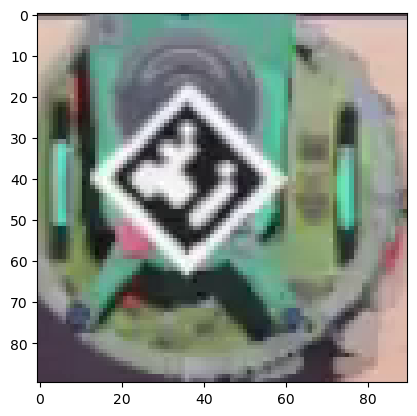

In [3]:
import cv2 as cv
# setup initial location of window
x, y, w, h = coordX-radius, coordY-radius, diameter, diameter # simply hardcoded the values of object in first frame
track_window = (x, y, w, h)
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

# set up the ROI for tracking object
roi = frame[y:y+h, x:x+w]
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
plt.imshow(roi)
plt.show()
mask = cv.inRange(hsv_roi, (15,0,89), (140,186,195)) #hsv values of object
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 60, 1 )
result = cv.VideoWriter('../MotionTrackingResult.avi',cv.VideoWriter_fourcc(*'MJPG'), 50, (1920,1080))

while(1):
    ret, frame = cap.read()
    if ret == True:
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        # apply camshift to get the new location
        ret, track_window = cv.CamShift(dst, track_window, term_crit)
        
        X = track_window[0]
        Y = track_window[1]
        text = str([X,Y])
        cv.putText(frame, text,(track_window[0]-20, track_window[1]-20),cv.FONT_HERSHEY_SIMPLEX,0.8,(0, 255, 0),2,cv.LINE_4)
        
        pts = cv.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv.polylines(frame,[pts],True, (0,255,0),2)
        
        result.write(img2)
        cv.imshow('img2',img2)
        if cv.waitKey(1) == ord('q'):
            break
    else:
        break
        
cv.destroyAllWindows()